# CS 5242 Homework 5

In this assignment, we are going to dive into autoencoders (AE) and variational autoencoders (VAE). AEs are powerful discriminative models while VAEs are widely used in generation tasks. 

### **Submission**

ASSIGNMENT DEADLINE ⏰ : **23:59 10 Apr 2024**

Rename this file as "{StuID}_{Name}_assignment-5.ipynb" (e.g., "A0100000J_Wang-Wenjie_assignment-5.ipynb"), and submit it to Canvas. Make sure all outputs are saved in this file as we will not run any code for you. Do **not** submit any other files, especially dataset files.


### **Contact**

Feel free to reach me if you have any question about this homework.

Slack: Xiangyu Peng

Email: xiangyupeng@comp.nus.edu.sg

## Task 1: Training an autoencoder (AE)
In task 1, the goal is to train an autoencoder (AE), which consists of an encoder and a decoder. AE is capable of learning meaningful representations in the latent space, which could be used for tasks like classification. Let's see how it works.

In [40]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Autoencoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, hidden_dim),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.flatten(1)
        x_enc = self.encoder(x)
        x_dec = self.decoder(x_enc)
        x_recon = x_dec.reshape(B, C, H, W)
        return x_recon

# Instantiate the model
input_dim = 28 * 28
hidden_dim = 32
model = Autoencoder(input_dim, hidden_dim).to(device)

We have prepared the dataset and the AE model for you. Your task is to implement the training code and meet the following requirements:
- use mean squared error (MSE) as the loss function
- use a proper optimizer and a proper learning rate
- train the model for 10 epochs
- plot the training loss curve (at least 10 points in the curve, since we train 10 epochs)

Epoch [1/10], Loss: 0.0453721284866333
Epoch [2/10], Loss: 0.029087163507938385
Epoch [3/10], Loss: 0.021590614691376686
Epoch [4/10], Loss: 0.016701392829418182
Epoch [5/10], Loss: 0.01687994971871376
Epoch [6/10], Loss: 0.015604298561811447
Epoch [7/10], Loss: 0.013186355121433735
Epoch [8/10], Loss: 0.011793447658419609
Epoch [9/10], Loss: 0.012256770394742489
Epoch [10/10], Loss: 0.013415345922112465


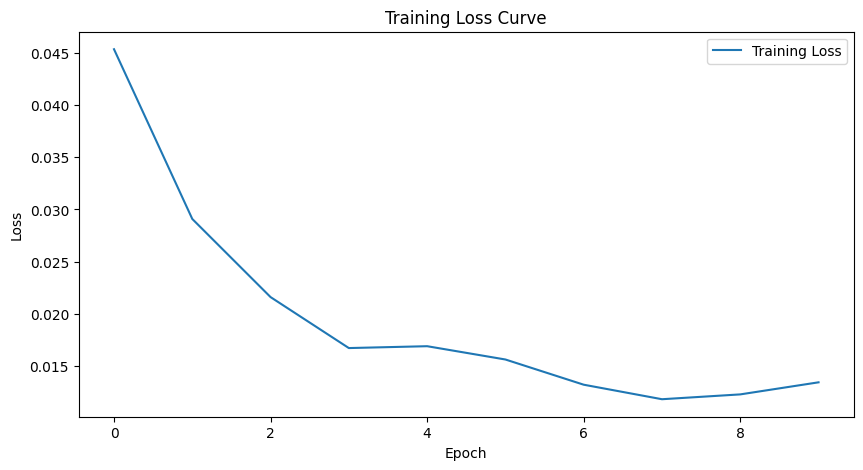

In [41]:
num_epochs = 10

# TODO: train the AE model (2 points)
##############################################
# Your code starts here
##############################################
import torch.optim as optim
import matplotlib.pyplot as plt

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# For plotting the training loss
losses = []

# Training loop
for epoch in range(num_epochs):
    for data in train_loader:
        # Transfer Data to GPU if available
        imgs, _ = data
        imgs = imgs.to(device)

        # Forward pass
        outputs = model(imgs)
        loss = criterion(outputs, imgs)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print loss every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')
    losses.append(loss.item())

# Plotting the training loss curve
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##############################################
# Your code ends here
##############################################

Verify your AE is well trained by visualizing reconstructed images.

Input Images:


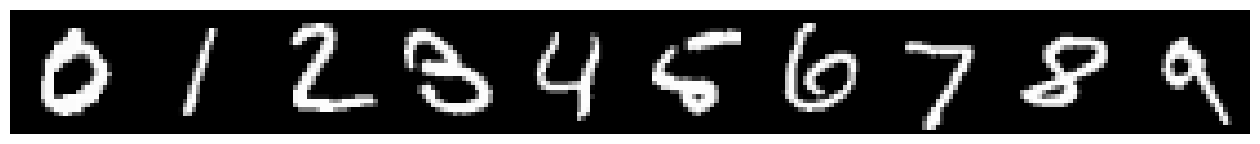

Reconstructed Images:


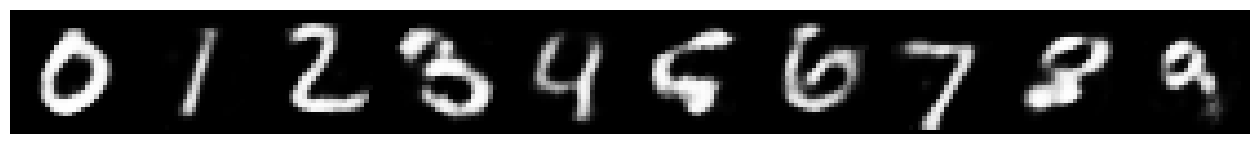

In [42]:
# Visualizing reconstructed images
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

sample_list = []
for idx_class in range(10):
    indices_i = (test_dataset.targets == idx_class).nonzero().view(-1)
    idx_sample = indices_i[0]
    sample = test_dataset[idx_sample]
    sample_list.append(sample[0])
x_orig = torch.stack(sample_list).to(device)

# Inference
model.eval()
with torch.no_grad():
    x_recon = model(x_orig)

# Plot the input and reconstructed images
imgs_orig = make_grid(x_orig, nrow=10, padding=0, normalize=True)
imgs_recon = make_grid(x_recon, nrow=10, padding=0, normalize=True)

print('Input Images:')
plt.figure(figsize=(16, 8))
plt.imshow(imgs_orig.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

print('Reconstructed Images:')
plt.figure(figsize=(16, 8))
plt.imshow(imgs_recon.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

Now we have trained an AE. Let's see how it can be used for classification. You are required to plot a [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) map of the latent representations output by the encoder. Implement the code below and follow these requirements:
- plot a 2D t-SNE map
- plot 20 samples for each class in the **test** set (i.e., 20 points for each digit from 0 to 9)
- use different colors for each digit

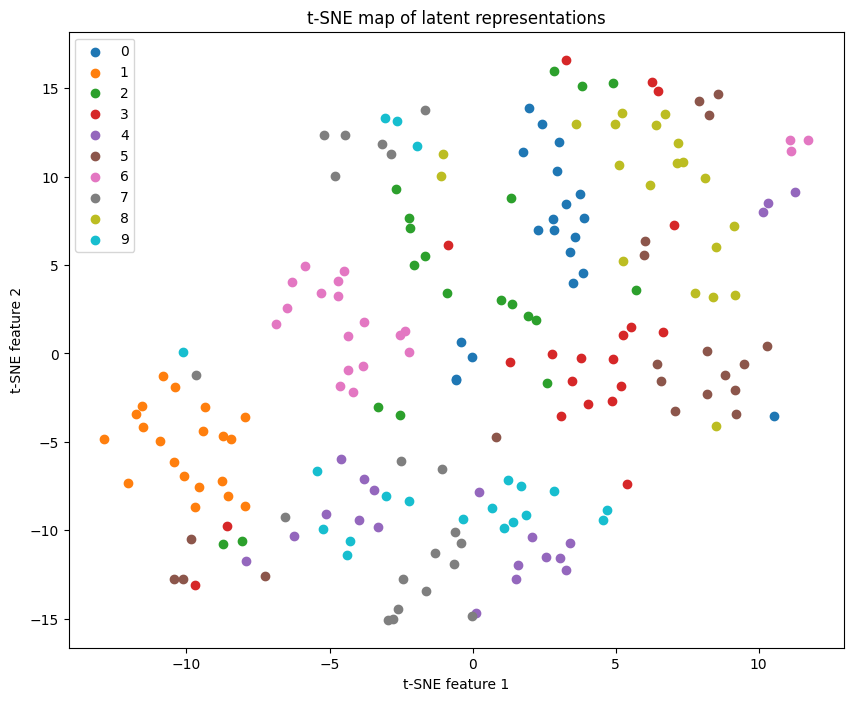

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# TODO: Plot t-SNE map (1.5 point)
##############################################
# Your code starts here
##############################################
# Prepare the data
latent_representations = []
labels = []

model.eval()  # Ensure the model is in evaluation mode

with torch.no_grad():
    for idx_class in range(10):  # For each class
        indices = (test_dataset.targets == idx_class).nonzero(as_tuple=True)[0][:20]
        for idx in indices:
            img, _ = test_dataset[idx]
            img = img.to(device).unsqueeze(0)  # Add batch dimension
            latent = model.encoder(img.view(1, -1))  # Extract latent representation
            latent_representations.append(latent.cpu().numpy())
            labels.append(idx_class)

# Apply t-SNE for dimensionality reduction
latent_representations = np.vstack(latent_representations)  # Convert list to numpy array
labels = np.array(labels)
tsne = TSNE(n_components=2, random_state=0)
latent_2d = tsne.fit_transform(latent_representations)

# Visualization
plt.figure(figsize=(10, 8))
for idx_class in range(10):
    indices = labels == idx_class
    plt.scatter(latent_2d[indices, 0], latent_2d[indices, 1], label=str(idx_class))

plt.legend()
plt.title('t-SNE map of latent representations')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()
##############################################
# Your code ends here
##############################################

Can you see the separation/classification of different digits?

## Task 2: Training a variational autoencoder (VAE)
We have trained an AE in task 1, which is demonstrated to be useful for classification. However, only the encoder of AE is used. The decoder part, which is capable of reconstruction, is wasted. Can we use the decoder for generating images?

The answer is yes. But some modifications are needed to achieve this goal. The general idea is to impose a prior distribution $p(z)$ on the latent space and constrain the learned distribution $q(z|x)$ to be close to $p(z)$, so that we can gain control over the learned latent distribution. Then, we can generate images using the decoder by sampling data points from the latent distribution. Actually, this is all about what a variational autoencoder (VAE) could do.

Typically, people use the standard normal distribution as the prior latent distribution (i.e., $p(z)= N(0, I)$), which has $ \mu=0 $ and $ \sigma=I $. 

In [57]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        self.mu = nn.Linear(256, latent_dim)
        self.log_var = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.flatten(1)

        h = self.encoder(x)

        mu, log_var = self.mu(h), self.log_var(h)
        z = self.reparameterize(mu, log_var)

        x_dec = self.decoder(z)
        x_recon = x_dec.reshape(B, C, H, W)

        return x_recon, mu, log_var

# Instantiate the model
input_dim = 28 * 28
latent_dim = 32
model = VAE(input_dim, latent_dim).to(device)

Again, We have prepared the dataset and the VAE model for you. Your task is to implement the training code and meet the following requirements:
- The loss function consists of 2 parts: 1) BinaryCrossEntropy (BCE) loss as the reconstruction loss; 2) KL divergence loss to minimize the distance between $q(z|x)$ and $p(z)$. Note that $p(z)= N(0, I)$
- use a proper optimizer and a proper learning rate
- train the model for 10 epochs
- plot the training loss curve (at least 10 points in the curve, since we train 10 epochs)

Epoch: 1, Avg Loss: 177.9753
Epoch: 2, Avg Loss: 129.4458
Epoch: 3, Avg Loss: 117.9853
Epoch: 4, Avg Loss: 112.9237
Epoch: 5, Avg Loss: 109.8127
Epoch: 6, Avg Loss: 107.6343
Epoch: 7, Avg Loss: 106.0925
Epoch: 8, Avg Loss: 104.9576
Epoch: 9, Avg Loss: 104.0572
Epoch: 10, Avg Loss: 103.2891


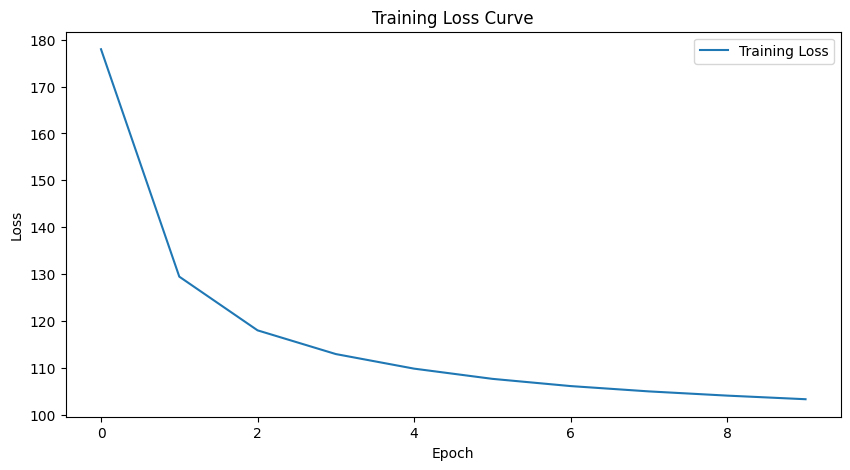

In [58]:
# TODO: train the VAE model (3 points)
##############################################
# Your code starts here
##############################################
import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Number of epochs
num_epochs = 10

# For plotting the training loss
train_loss_over_epochs = []

# Training function
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = model(data)

        # Calculate loss
        recon_loss = F.binary_cross_entropy(recon_batch, data, reduction='sum')
        kl_div_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kl_div_loss

        # Backward pass
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    # Average loss for this epoch
    avg_loss = train_loss / len(train_loader.dataset)
    train_loss_over_epochs.append(avg_loss)
    print(f'Epoch: {epoch}, Avg Loss: {avg_loss:.4f}')

# Train the VAE
for epoch in range(1, num_epochs + 1):
    train(epoch)

# Plot the training loss curve
plt.figure(figsize=(10, 5))
plt.plot(train_loss_over_epochs, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
##############################################
# Your code ends here
##############################################

Also, verify the sanity of the VAE model by visualizing reconstructed images.

Input Images:


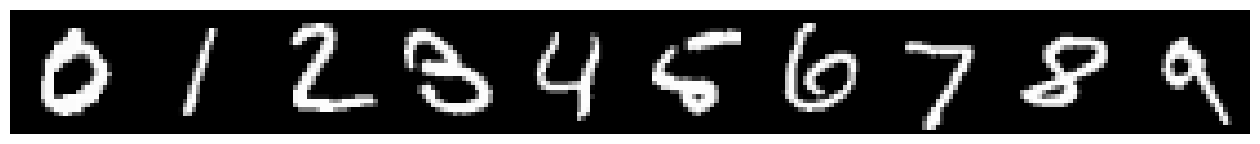

Reconstructed Images:


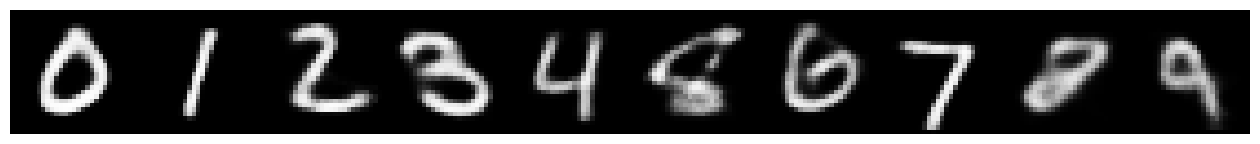

In [59]:
# Visualizing reconstructed images
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

sample_list = []
for idx_class in range(10):
    indices_i = (test_dataset.targets == idx_class).nonzero().view(-1)
    idx_sample = indices_i[0]
    sample = test_dataset[idx_sample]
    sample_list.append(sample[0])
x_orig = torch.stack(sample_list).to(device)

# Inference
model.eval()
with torch.no_grad():
    x_recon, mu, log_var = model(x_orig)

# Plot the input and reconstructed images
imgs_orig = make_grid(x_orig, nrow=10, padding=0, normalize=True)
imgs_recon = make_grid(x_recon, nrow=10, padding=0, normalize=True)

print('Input Images:')
plt.figure(figsize=(16, 8))
plt.imshow(imgs_orig.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

print('Reconstructed Images:')
plt.figure(figsize=(16, 8))
plt.imshow(imgs_recon.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

Now we have trained a VAE. Let's first check its latent distribution like we do for AE. You are required to plot a [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) map of the latent representations output by the VAE encoder. Implement the code below and follow these requirements:
- plot a 2D t-SNE map
- plot 20 samples for each class in the **test** set (i.e., 20 points for each digit from 0 to 9)
- use different colors for each digit

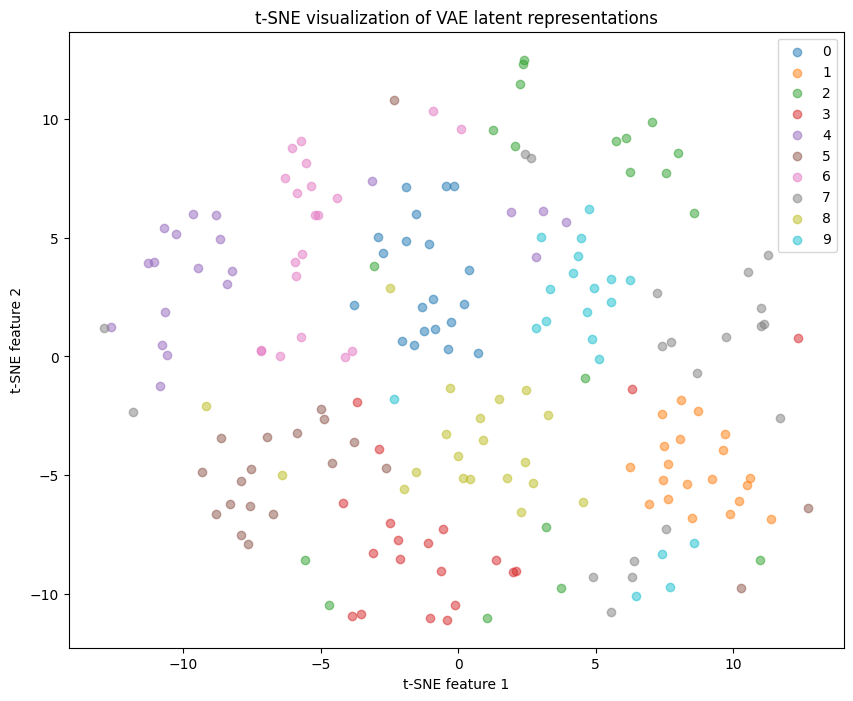

In [61]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# TODO: Plot t-SNE map (1.5 point)
##############################################
# Your code starts here
##############################################
# Ensure the model is in evaluation mode
model.eval()

# Prepare to store latent vectors and their labels
latent_vectors = []
labels = []

# Process each digit class in the test set
with torch.no_grad():
    for digit in range(10):
        # Find indices of 20 samples for the current digit
        indices = (test_dataset.targets == digit).nonzero(as_tuple=True)[0][:20]
        for idx in indices:
            img, _ = test_dataset[idx]
            img = img.to(device).unsqueeze(0)  # Add batch dimension and move to the device
            _, mu, _ = model(img)  # Pass the image through the model to get the latent space representation (mu)
            latent_vectors.append(mu.squeeze().cpu().numpy())  # Remove batch dimension and move to CPU
            labels.append(digit)

# Convert lists to arrays
latent_vectors = np.array(latent_vectors)
labels = np.array(labels)

# Perform t-SNE transformation
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(latent_vectors)

# Plotting
plt.figure(figsize=(10, 8))
for digit in range(10):
    indices = labels == digit
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=str(digit), alpha=0.5)

plt.legend()
plt.title('t-SNE visualization of VAE latent representations')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

##############################################
# Your code ends here
##############################################

Finally, we are able to generate images using the decoder of the VAE by sampling data points from $p(z)$. Implement the code below and meet these requirements:
- sample 10 data points from $p(z)$
- show them 5 images in a row, 2 rows in total
- at least one image should be recognized as a digit

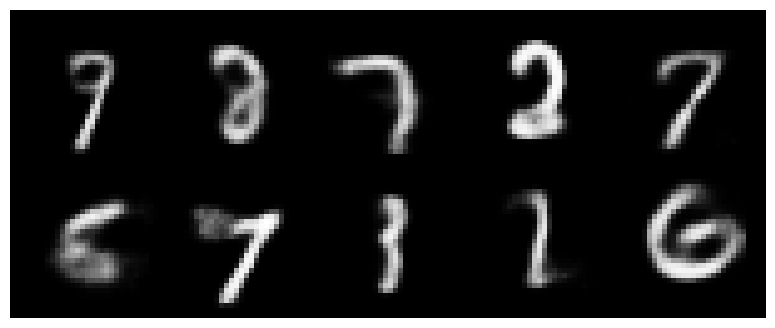

In [66]:
# TODO: generate digits using the decoder of VAE (1 point)
##############################################
# Your code starts here
##############################################
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Sample 10 data points from p(z) = N(0, I)
latent_dim = 32  # Assuming this is your latent dimension
z = torch.randn(10, latent_dim).to(device)

# Decode the sampled data points to generate images
model.eval()
with torch.no_grad():
    generated_images = model.decoder(z)

# Reshape the output to create valid images
generated_images = generated_images.view(-1, 1, 28, 28)

# Create a grid of images
grid = make_grid(generated_images, nrow=5, normalize=True)

# Visualize the generated images
plt.figure(figsize=(10, 4))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()
##############################################
# Your code ends here
##############################################

Open question: We can now generate digits by sampling from the latent distribution. But we cannot control which digit to generate. Do you have any idea about how can we manage to generate any digit we want?

In [ ]:
# TODO: Your answer here (1 point)
'''
After completing the homework and learning about VAEs, I think the best way to control which digit we generate is by using a Conditional Variational Autoencoder (CVAE). Unlike the basic VAE that we worked with, where we just sample from the latent space without any control over what we generate, a CVAE incorporates additional label information during the training process. This allows us to condition the generation on specific labels, meaning we can choose which digit to generate.

Here’s how it works: In a CVAE, both the encoder and decoder are conditioned on the labels of the data. When we encode an input, we also provide the label as part of the input to the encoder, which helps the model learn a conditional latent representation. Similarly, when we want to generate a new image, we sample from the latent space as usual, but we also provide a label to the decoder specifying which digit we want to generate.

For example, if we want to generate the digit "5", we would sample a point from the latent space and pass it to the decoder along with the label for "5". The decoder, being trained on how to decode each region of the latent space based on the given labels, will then generate an image of the digit "5".

This approach not only gives us control over the digit we want to generate but also improves the diversity and quality of the generated images, as the model learns distinct representations for each digit in the conditioned latent space.
'''